## 01. 미국 ETF (QQQ) 주가 예측하기 ##

링크: https://finance.yahoo.com/quote/QQQ/history?p=QQQ
* QQQ는 NASDA을 추종하는 ETF이다.

### (1) 필요한 함수 가져오기 ###

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

print('Done!')

Done!


### (2) 시계열 데이터 준비하기 ###

In [63]:
# Time Series 시계열 데이터 준비

data_path = os.getenv('HOME') + '/aiffel/exploration/E_03/QQQ.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-05-03    336.190002
2021-05-04    330.140015
2021-05-05    329.029999
2021-05-06    331.510010
2021-05-07    334.200012
Name: Close, dtype: float64

### (3) 결측치 처리하기 ###

In [64]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series[]로 출력 / 없음

Series([], Name: Close, dtype: float64)

### (4) 로그 변환 ###

In [65]:
# 주가는 변동폭이 계속 바뀌므로 로그 변환
ts_log = np.log(ts)
print('Done!')

Done!


### (5) 안정성 분석을 위한 사전 작업 ###

In [66]:
## 구간 통계치 (rolling statistics) 시각화 함수

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
## ADF Test 함수
# 주어진 시계열이 불안정하다 (귀무가설)

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지의 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller에서 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    
print('Done!')

Done!


### (6) 시계열 안정성 분석 ###

### (6-1) 정성적 그래프 분석 ###

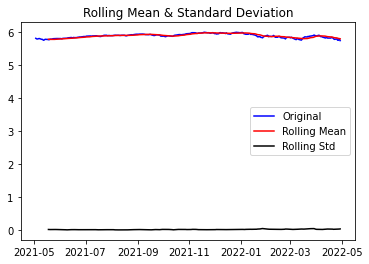

In [67]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

### (6-2) 정량적 ADF test

In [68]:
#정량적 ADF test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.276861
p-value                          0.639691
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


### (6-3) 시계열 분해

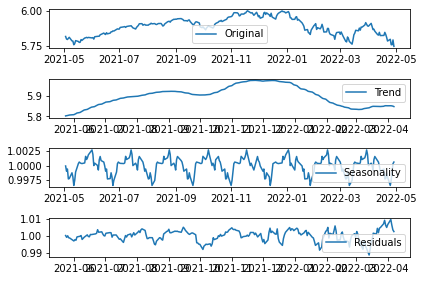

In [69]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### (6-4) Residual 안정성 확인

In [70]:
# Residual

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.298481
p-value                          0.000006
#Lags Used                      14.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


### (7) 학습/테스트 데이터셋 분리

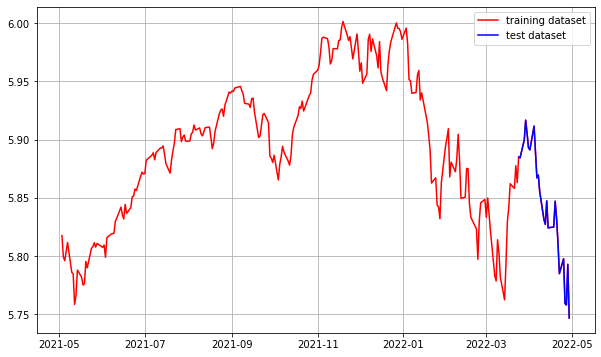

In [71]:
# 학습 비율 90%
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # ts_log로 자연스러운 그래프 사용
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### (8) 적정 ARIMA 수 구하기

### (8-1) ACF, PACF 그리기 (p, q 구하기)

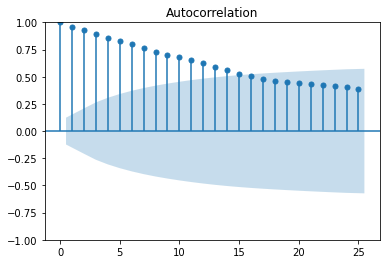

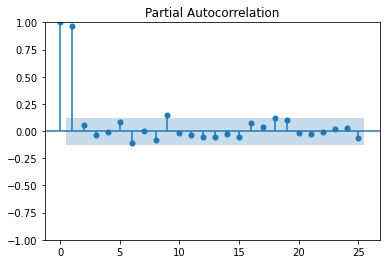

In [72]:
# ACF, PACF -> p, q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()         

## p = 20 즈음에서 0에 가깝다.

### (8-2) 차분 안정성 확인 (d 구하기)


Results of Dickey-Fuller Test:
Test Statistic                -1.545154e+01
p-value                        2.780048e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.389871e+00
p-value                        2.382643e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


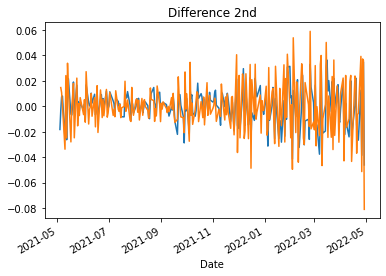

In [73]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# d = 2일때 p값이 더 낮다.

### (9) ARIMA 모델 훈련 & 테스트

### (9-1) 모델 빌드 & fitting

In [86]:
# Build Model

model = ARIMA(train_data, order=(20, 2, 2))  # p=20, d=2, q=2
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(20, 2, 2)   Log Likelihood                 658.158
Date:                Sun, 01 May 2022   AIC                          -1270.316
Time:                        14:47:13   BIC                          -1191.848
Sample:                             0   HQIC                         -1238.642
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5246    195.943     -0.003      0.998    -384.566     383.517
ar.L2         -0.2699     30.227     -0.009      0.993     -59.515      58.975
ar.L3         -0.3223     41.399     -0.008      0.9

### (9-2) 결과 시각화

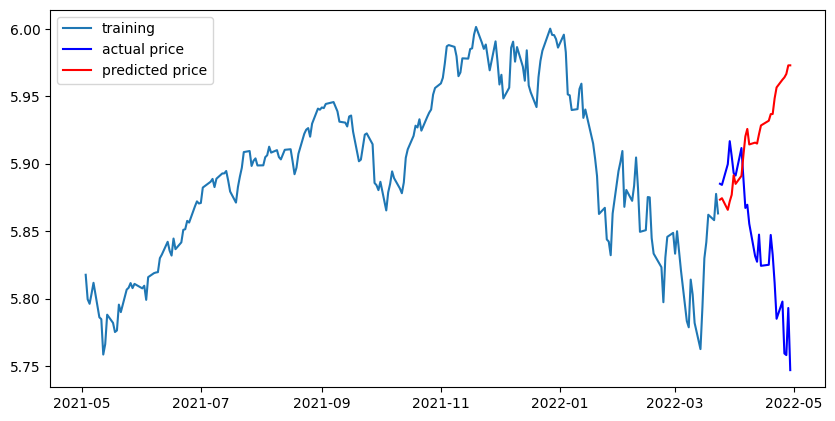

In [87]:
# Forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)


# pandas series로 변환
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot으로 시각화
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### (9-3) 정확도 판정

In [88]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1553.5267944453958
MAE:  31.352613316403676
RMSE:  39.41480425481517
MAPE: 9.42%


### SPY ETF 분석
* S&P500 추종 ETF

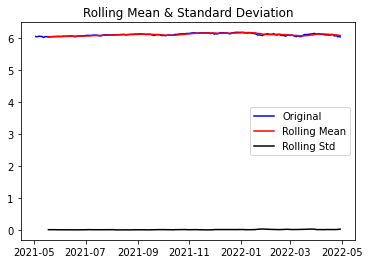

Results of Dickey-Fuller Test:
Test Statistic                  -2.014766
p-value                          0.280137
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.274312
p-value                          0.000006
#Lags Used                       1.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


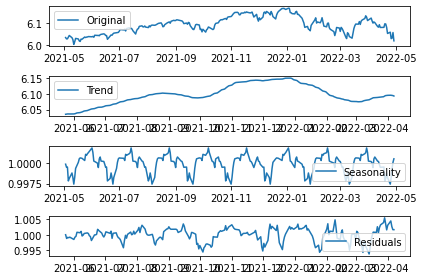

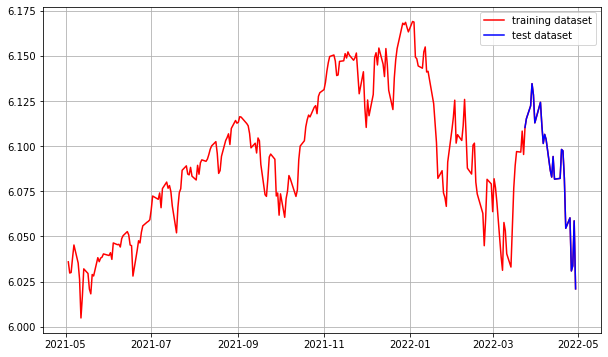

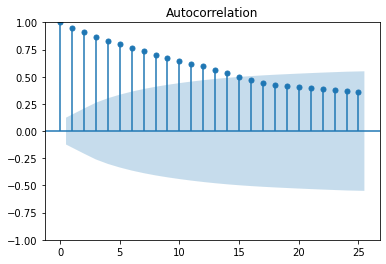

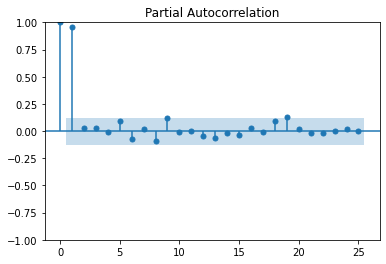

Results of Dickey-Fuller Test:
Test Statistic                -1.227214e+01
p-value                        8.592709e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.137358e+00
p-value                        1.050447e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


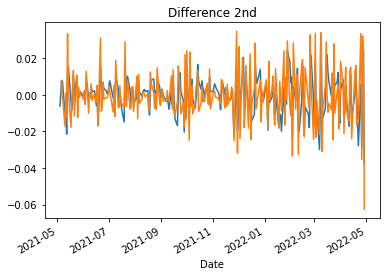

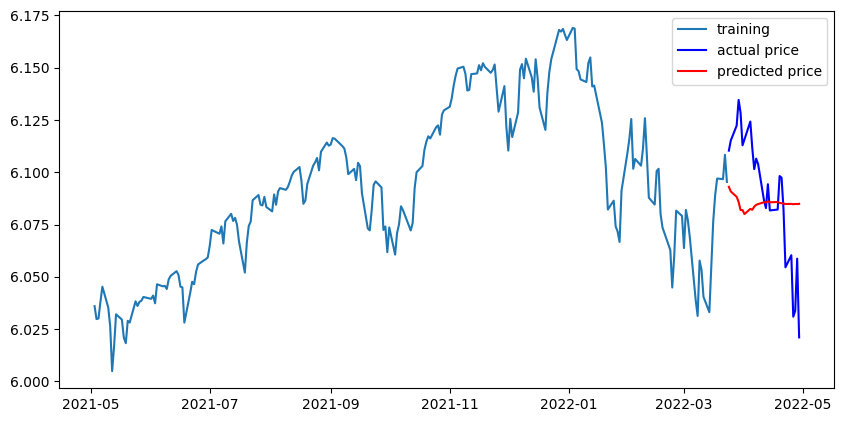

MSE:  183.23820848477988
MAE:  11.238975696687227
RMSE:  13.536550834122401
MAPE: 2.56%


In [90]:
# 편의상 위 과정을 모듈화하여 사용
import arima_pred

# pred(p, d, q, train_rate, file_path)
# arima_pred.arm_pred(2, 1, 2, 0.9, '/aiffel/exploration/E_03/SPY.csv') # 초기값 임의 배정 후 보정
arima_pred.arm_pred(10, 1, 2, 0.9, '/aiffel/exploration/E_03/SPY.csv')


### ESGU ETF 분석
* ESG Theme ETF

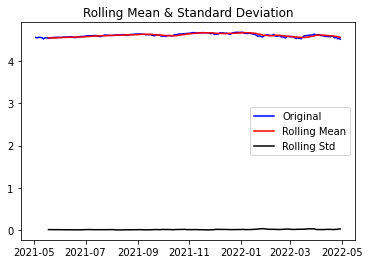

Results of Dickey-Fuller Test:
Test Statistic                  -1.728683
p-value                          0.416398
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.036955
p-value                          0.000019
#Lags Used                      14.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


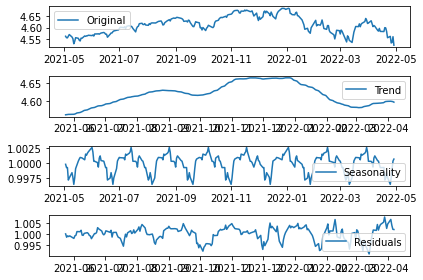

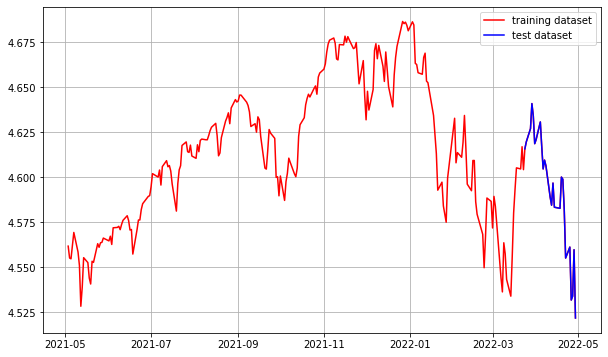

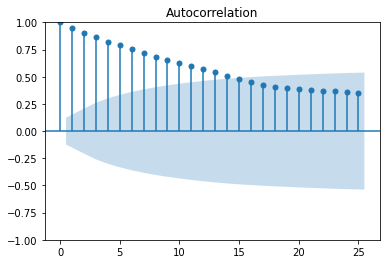

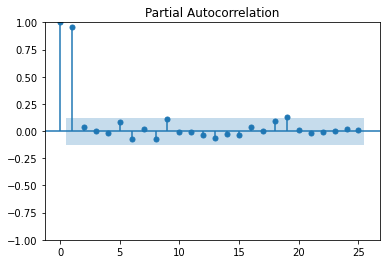

Results of Dickey-Fuller Test:
Test Statistic                -1.218186e+01
p-value                        1.345838e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.256911e+00
p-value                        5.207402e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


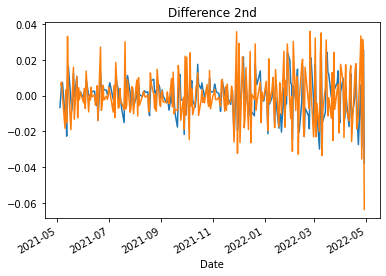

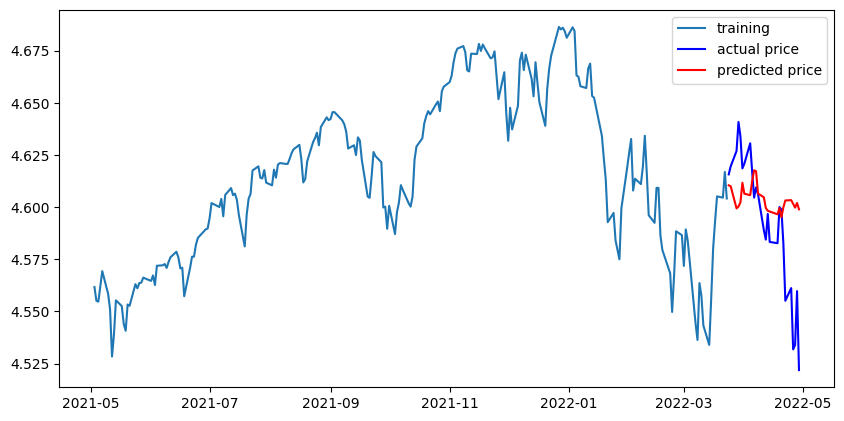

MSE:  9.799642965171321
MAE:  2.3203502489485217
RMSE:  3.130438142684075
MAPE: 2.40%


In [91]:
arima_pred.arm_pred(20, 1, 1, 0.9, '/aiffel/exploration/E_03/ESGU.csv')

# <span style="color:orange"> 후기 </span> 

주가는 생각보다 맞추기 어려웠다.


특히 MAPE 값이 3% 이내로 낮아도 주가의 변동이 극심한 부분은 단순 ARIMA 모델로 예측할 수 없는 거대한 외부 변수(e.g. 러-우 전쟁)의 영향인 것 같다. 보통 종목 분석을 할 때, 정량적 분석과 정성적 분석을 동시에 진행하는데 ARIMA 모델은 정량적 분석의 정확도를 끌어올리는 데는 유용해 보인다.

일부러 크고 작은 외부 변수의 영향력을 줄이고자 지수추종형 펀드들을 분석해봤는데, 그럼에도 불구하고 외부 변수의 영향력이 생각보다 강했다. 이렇게 외부 변수의 영향력이 강하면 차분이 제일 유효한 분석방식일 것 같았는데 그게 아닌 점도 의외였다. 그 이유는 아직 잘 모르겠지만, 인공지능을 주식 예측에 사용하려고 배우는 사람들이 많으니까 아마 이런 부분까지 고려한 모델이 분명히 있을 것이다. 또, 차트의 데이터에만 의존하는 ARIMA 특성 상, 정성적 분석보다 정량적 분석이 더 잘 맞는 경향이 있는 암호화폐류 분석에 더 유용하지 않을까?